# Stat441/841 - Fall 2019 - Final Project

Hieu Nguyen - Jacob Raymond - Dingding Hu

--

# Preprocessing

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
import warnings
pd.set_option("display.max_columns", 100)
warnings.filterwarnings(action="ignore")

# define one hot encoding for categorical var


def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    categorical_columns.remove("deposit")
    # apply drop_first to deal with multicollinearity
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category, drop_first=True)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Memory reduction: some members do not have sufficient compuation capacity


def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


def transform_pipeline(data):
    df = data.copy()
    # log transform balance
    df["balance"] = np.log(df["balance"] + abs(df["balance"].min()) + 1)
    # transformation in categorical features
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        if col not in ["contact", "poutcome"]:
            """
            besides contact and poutcome variables, "unknown" values will be replaced
            by the mode in each categorical column
            """
            data[col].replace('unknown', data[col].mode()[0], inplace=True)
    # replace -1 by 999
    df["pdays"].replace(-1, 999, inplace=True)
    # regroup the months into 3 main groups: early, mid, end of each quarter in a year
    df["month"] = df["month"].apply(lambda x: "EarlyQuarter" if (x in ["jan", "apr", "jul", "oct"])
                                    else ("MidQuarter" if (x in ["feb", "may", "aug", "oct"]) else
                                          "EndQuarter"))
    # regroup the day into 3 main groups based on the density of y/n ratios
    df["day"] = df["day"].apply(lambda x: "gr1" if (x in [1, 10])
                                else ("gr2" if (x in [19, 20, 28, 29, 31]) else "gr3"))
    # replace other with unknown
    df["poutcome"].replace("other", "unknown", inplace=True)

    # apply one hot encoding on categorical variables
    df, _ = one_hot_encoder(df)

    # get rid of some of the null columns
    for col in ["month_nan", "contact_nan", "loan_nan", "housing_nan", "default_nan",
                "education_nan", "marital_nan", "job_nan", "day_nan", "poutcome_nan"]:
        del df[col]
    # memory optimization before outputing the final dataframe
    df = reduce_mem_usage(df)
    return df


def normalization(traindf, df):
    for col in ["age", "balance", "duration", "campaign", "pdays", "previous"]:
        if col != "balance":
            df[col] = (df[col] - traindf[col].mean()) / traindf[col].std()
        else:
            # for some reasons trainset["balance"].mean() results into "inf" after the log transformation so we hard coded the train mean here
            train_mean = 8.995432292407646
            df[col] = (df[col] - train_mean) / traindf[col].std()
    return df


def split_data(df):
    # Shuffle dataframe
    df = df.sample(frac=1).reset_index(drop=True)

    # train test split: 70/30 ratio from the entire data set
    trainset, testset = train_test_split(df, test_size=0.3, random_state=44119)
    # split valid and test: 50/50 ratio from the test set
    validset, testset = train_test_split(testset, test_size=0.5, random_state=44119)

    # normalization
    trainset = normalization(trainset, trainset)
    validset = normalization(trainset, validset)
    testset = normalization(trainset, testset)
    return trainset, validset, testset


def main():
    df = pd.read_csv("data/bank.csv", sep=",")
    df = transform_pipeline(df)
    train, valid, test = split_data(df)
    return train, valid, test

In [7]:
%time
train, valid, test = main()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs
Memory usage after optimization is: 0.47 MB
Decreased by 47.0%


# Training Set

In [29]:
train.iloc[:5,:7]

age   balance  duration  campaign    pdays  previous deposit
8469 -0.436501 -0.486816 -0.025978 -0.547725  0.56975 -0.367423      no
4868  0.572115 -0.519043  0.231463  1.629889  0.56975 -0.367423     yes
4356  1.412627  0.097351 -0.571980  0.904018  0.56975 -0.367423      no
711  -0.352450 -0.227173 -0.639876 -0.184789  0.56975 -0.367423     yes
47    0.067807  0.097351 -0.710602  1.992825  0.56975 -0.367423      no

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7813 entries, 8469 to 6137
Data columns (total 34 columns):
age                    7813 non-null float64
balance                7813 non-null float16
duration               7813 non-null float64
campaign               7813 non-null float64
pdays                  7813 non-null float64
previous               7813 non-null float64
deposit                7813 non-null object
job_blue-collar        7813 non-null uint8
job_entrepreneur       7813 non-null uint8
job_housemaid          7813 non-null uint8
job_management         7813 non-null uint8
job_retired            7813 non-null uint8
job_self-employed      7813 non-null uint8
job_services           7813 non-null uint8
job_student            7813 non-null uint8
job_technician         7813 non-null uint8
job_unemployed         7813 non-null uint8
job_unknown            7813 non-null uint8
marital_married        7813 non-null uint8
marital_single         7813 non-null uint8
education_seconda

In [24]:
train.iloc[:,:7].describe()

age      balance      duration      campaign         pdays  \
count  7.813000e+03  7813.000000  7.813000e+03  7.813000e+03  7.813000e+03   
mean   2.546422e-17     0.020981  6.320584e-17  2.410007e-17 -8.548703e-17   
std    1.000000e+00     0.999512  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.949424e+00    -3.115234 -1.058572e+00 -5.477248e-01 -2.277326e+00   
25%   -7.727060e-01    -0.583984 -6.709956e-01 -5.477248e-01 -4.359829e-02   
50%   -1.843470e-01    -0.356934 -3.371707e-01 -1.847892e-01  5.697495e-01   
75%    6.561659e-01     0.259521  3.361373e-01  1.781464e-01  5.697495e-01   
max    4.522525e+00     9.929688  9.915216e+00  2.195428e+01  5.697495e-01   

           previous  
count  7.813000e+03  
mean  -4.365295e-17  
std    1.000000e+00  
min   -3.674228e-01  
25%   -3.674228e-01  
50%   -3.674228e-01  
75%    8.035046e-02  
max    2.560343e+01

# Valid Set

In [20]:
valid.iloc[:5,:7].head()

age   balance  duration  campaign  pdays      previous deposit
7100   29.0 -0.093811     403.0       1.0  999.0  4.365295e-17     yes
10480  42.0 -0.156372     795.0       1.0  999.0  4.365295e-17     yes
1231   32.0  0.406494     232.0       2.0  183.0  2.000000e+00      no
9483   38.0  0.398682     370.0       1.0  184.0  1.000000e+00      no
5986   40.0 -0.109436     365.0       1.0  100.0  2.000000e+00      no

In [16]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1674 entries, 7100 to 2052
Data columns (total 34 columns):
age                    1674 non-null float64
balance                1674 non-null float16
duration               1674 non-null float64
campaign               1674 non-null float64
pdays                  1674 non-null float64
previous               1674 non-null float64
deposit                1674 non-null object
job_blue-collar        1674 non-null uint8
job_entrepreneur       1674 non-null uint8
job_housemaid          1674 non-null uint8
job_management         1674 non-null uint8
job_retired            1674 non-null uint8
job_self-employed      1674 non-null uint8
job_services           1674 non-null uint8
job_student            1674 non-null uint8
job_technician         1674 non-null uint8
job_unemployed         1674 non-null uint8
job_unknown            1674 non-null uint8
marital_married        1674 non-null uint8
marital_single         1674 non-null uint8
education_seconda

In [23]:
valid.iloc[:,:7].describe()

age      balance     duration     campaign        pdays  \
count  1674.000000  1674.000000  1674.000000  1674.000000  1674.000000   
mean     41.286738    -0.007286   371.126643     2.484468   792.056153   
std      12.075830     0.329590   340.480157     2.661193   353.447033   
min      18.000000    -9.000000     7.000000     1.000000     1.000000   
25%      32.000000    -0.148560   137.000000     1.000000   403.250000   
50%      39.000000    -0.093811   254.500000     2.000000   999.000000   
75%      49.000000     0.046906   517.000000     3.000000   999.000000   
max      88.000000     2.001953  2769.000000    43.000000   999.000000   

           previous  
count  1.674000e+03  
mean   8.351254e-01  
std    2.283088e+00  
min    4.365295e-17  
25%    4.365295e-17  
50%    4.365295e-17  
75%    1.000000e+00  
max    4.100000e+01

# Test Set

In [27]:
test.iloc[:5,:7]

age   balance  duration  campaign  pdays      previous deposit
7420  26.0 -0.046906     156.0       1.0  199.0  1.000000e+00     yes
31    32.0 -0.164185     653.0       1.0  999.0  4.365295e-17     yes
9573  25.0 -0.070374     266.0       1.0  999.0  4.365295e-17      no
9787  32.0 -0.140747     158.0       2.0  999.0  4.365295e-17     yes
6195  29.0  0.516113     792.0       2.0  298.0  1.000000e+00     yes

In [30]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1675 entries, 7420 to 5715
Data columns (total 34 columns):
age                    1675 non-null float64
balance                1675 non-null float16
duration               1675 non-null float64
campaign               1675 non-null float64
pdays                  1675 non-null float64
previous               1675 non-null float64
deposit                1675 non-null object
job_blue-collar        1675 non-null uint8
job_entrepreneur       1675 non-null uint8
job_housemaid          1675 non-null uint8
job_management         1675 non-null uint8
job_retired            1675 non-null uint8
job_self-employed      1675 non-null uint8
job_services           1675 non-null uint8
job_student            1675 non-null uint8
job_technician         1675 non-null uint8
job_unemployed         1675 non-null uint8
job_unknown            1675 non-null uint8
marital_married        1675 non-null uint8
marital_single         1675 non-null uint8
education_seconda

In [31]:
test.iloc[:,:7].describe()

age      balance     duration     campaign        pdays  \
count  1675.000000  1675.000000  1675.000000  1675.000000  1675.000000   
mean     41.357612     0.003918   353.321791     2.528955   791.792239   
std      11.829655     0.229004   322.516634     2.625960   352.680099   
min      18.000000    -0.664551     5.000000     1.000000     1.000000   
25%      32.000000    -0.140747   138.000000     1.000000   404.500000   
50%      39.000000    -0.078186   247.000000     2.000000   999.000000   
75%      49.000000     0.070374   482.000000     3.000000   999.000000   
max      93.000000     1.641602  3284.000000    27.000000   999.000000   

           previous  
count  1.675000e+03  
mean   8.859701e-01  
std    2.556789e+00  
min    4.365295e-17  
25%    4.365295e-17  
50%    4.365295e-17  
75%    1.000000e+00  
max    5.500000e+01

# Exploration

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set_style('darkgrid')
sns.set_palette('colorblind')
plt.figure(figsize = (15,13))
sns.set(rc={'figure.figsize':(15,13)})
sns.set(style="ticks", color_codes=True)
warnings.filterwarnings(action="ignore")
# pd.set_option("display.min_rows",4)

<Figure size 1080x936 with 0 Axes>

In [5]:
data = pd.read_csv("data/bank.csv", sep=",")
data.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

## Missing Values

In [6]:
columns = data.columns
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing (%)': percent_missing})
missing_value_df.sort_values('percent_missing (%)', inplace=True, ascending=False)
missing_value_df.head(50)

column_name  percent_missing (%)
age               age                  0.0
day               day                  0.0
poutcome     poutcome                  0.0
previous     previous                  0.0
pdays           pdays                  0.0
campaign     campaign                  0.0
duration     duration                  0.0
month           month                  0.0
contact       contact                  0.0
job               job                  0.0
loan             loan                  0.0
housing       housing                  0.0
balance       balance                  0.0
default       default                  0.0
education   education                  0.0
marital       marital                  0.0
deposit       deposit                  0.0

## Correlation between Numerical Features

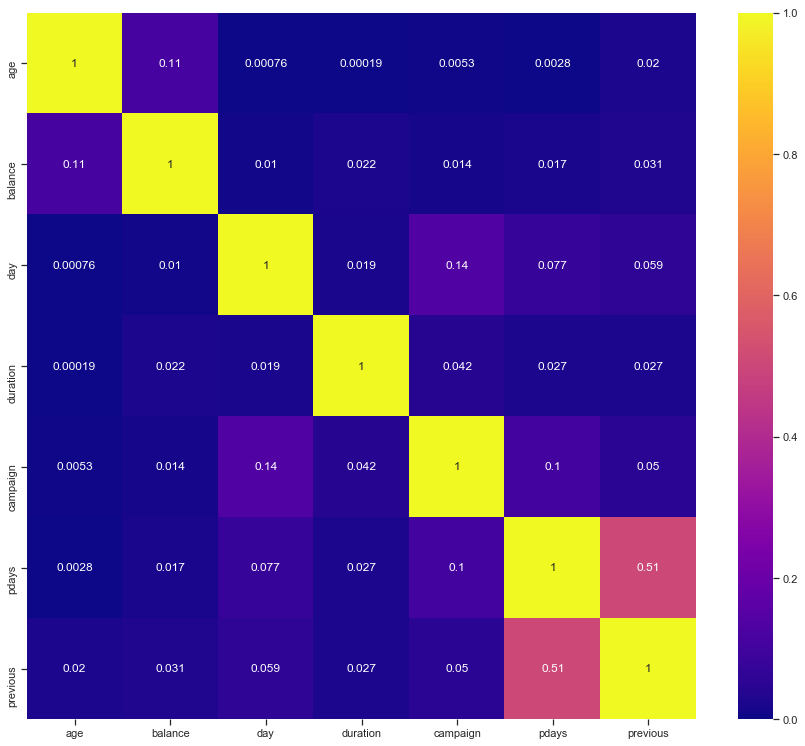

In [10]:
# calculate the correlation matrix
data["ID"] =  data.index

# plt.clf()
# calculate the correlation matrix
corr = data.drop(['ID'], axis = 1).corr().abs()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap="plasma", annot=True)
# plt.savefig('/Users/hq2nguye/Desktop/stat441_project/images/corr_heatmap.png')

# Log transformation of "balance"

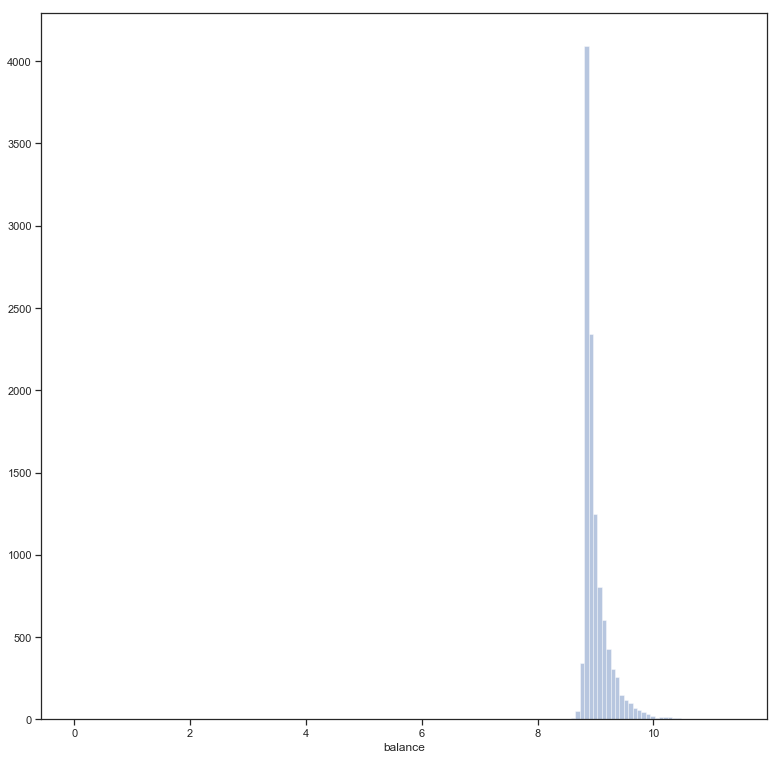

In [11]:
test = data.copy()
plt.figure(figsize = (13,13))

sns.distplot(np.log(test["balance"] + 6848), bins =150, kde = False)

# p#lt.savefig('/Users/hq2nguye/Desktop/stat441_project/images/logtransform_balance.png')

## Pair Plot

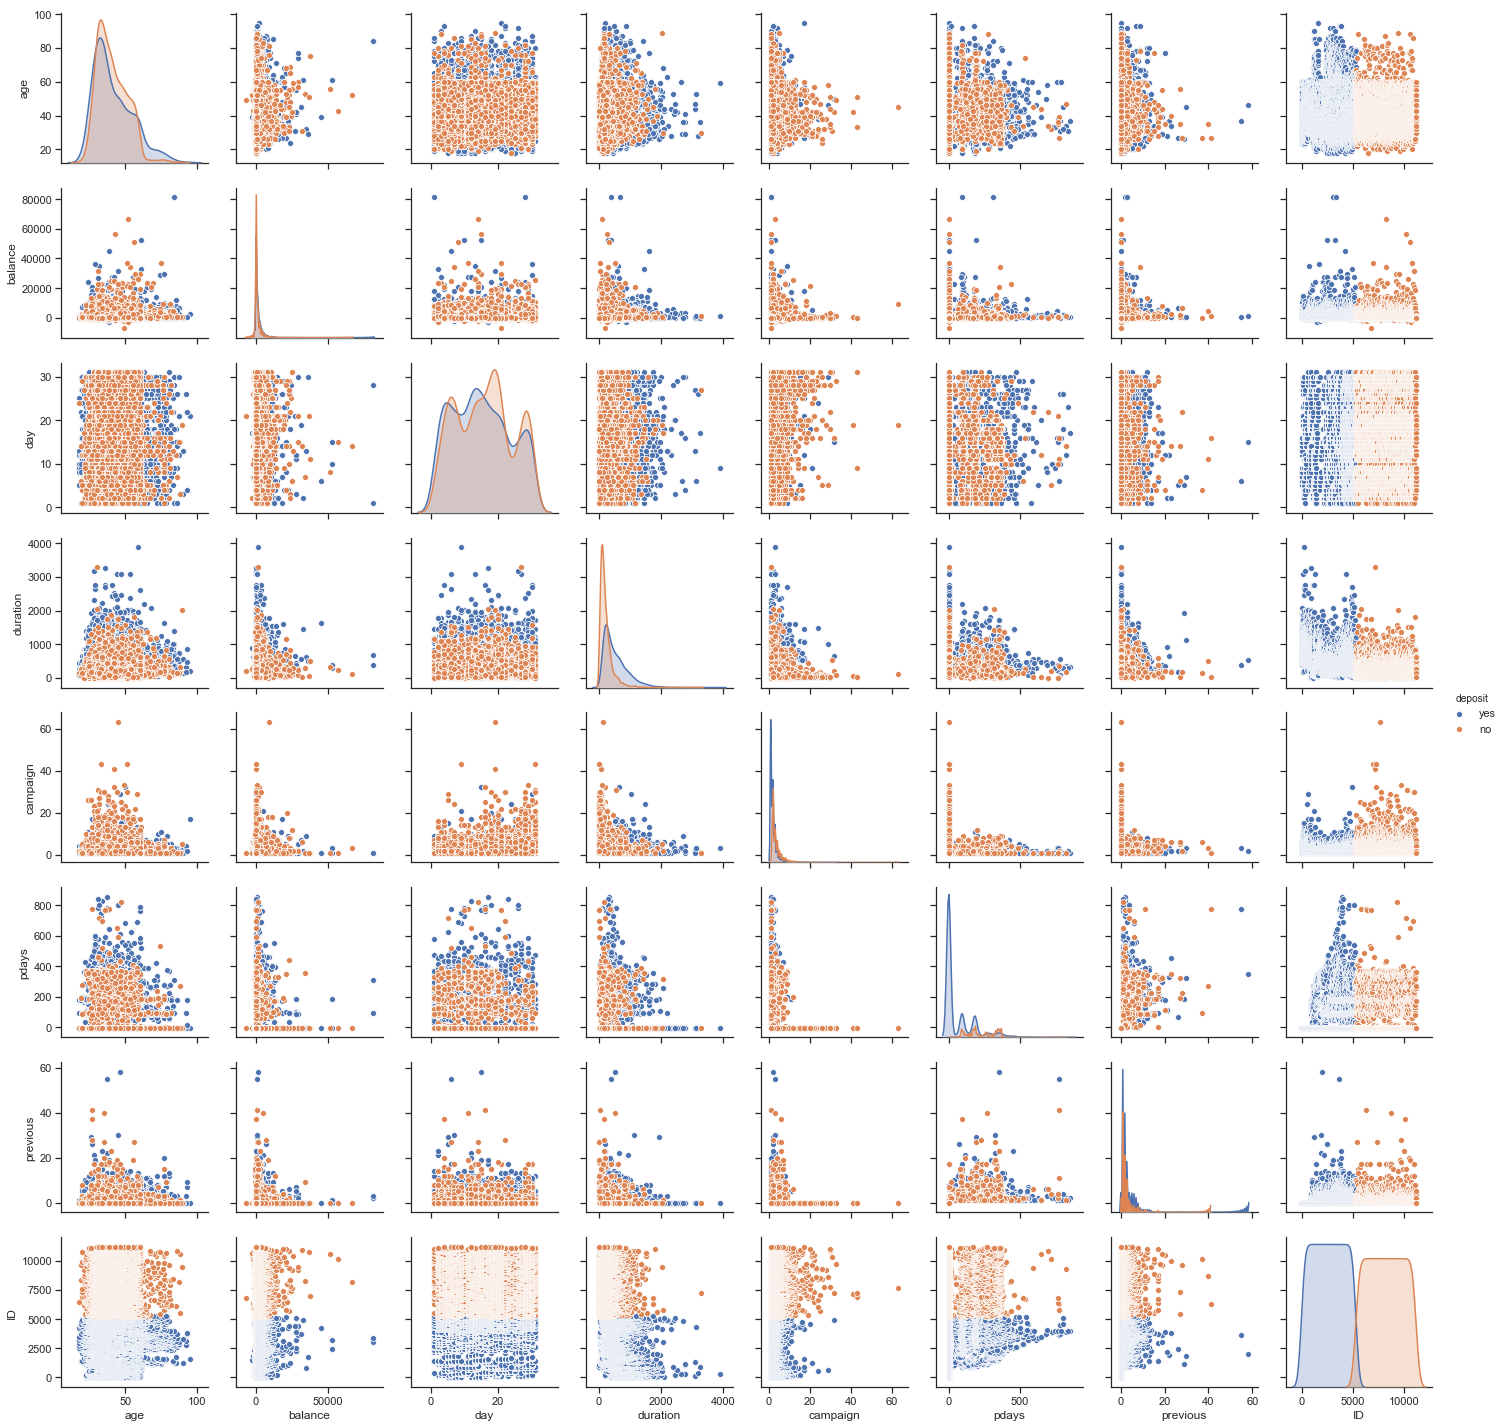

In [12]:
sns.pairplot(data, hue="deposit")

## Explore deeper with positive responders

job
student          0.747222
retired          0.663239
unemployed       0.565826
management       0.507015
unknown          0.485714
admin.           0.473013
self-employed    0.461728
technician       0.460779
services         0.399783
housemaid        0.397810
entrepreneur     0.375000
blue-collar      0.364198
Name: percentage_deposit, dtype: float64


marital
single      0.543491
divorced    0.481052
married     0.433790
Name: percentage_deposit, dtype: float64


education
tertiary     0.541068
unknown      0.507042
secondary    0.447407
primary      0.394000
Name: percentage_deposit, dtype: float64


default
no     0.476351
yes    0.309524
Name: percentage_deposit, dtype: float64


housing
no     0.570311
yes    0.366408
Name: percentage_deposit, dtype: float64


loan
no     0.495259
yes    0.331507
Name: percentage_deposit, dtype: float64


contact
cellular     0.543273
telephone    0.503876
unknown      0.225916
Name: percentage_deposit, dtype: float64


month
dec    0.909091
m

<Figure size 936x936 with 0 Axes>

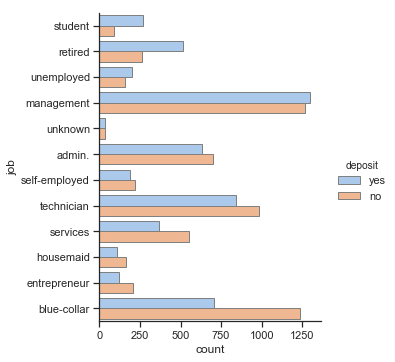

<Figure size 936x936 with 0 Axes>

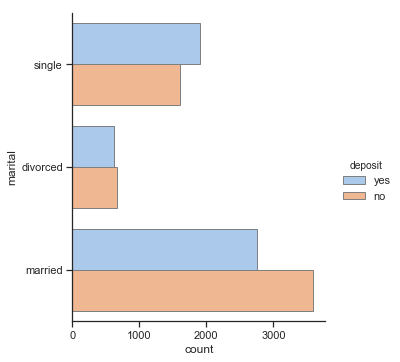

<Figure size 936x936 with 0 Axes>

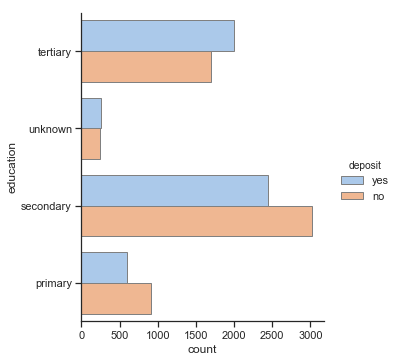

<Figure size 936x936 with 0 Axes>

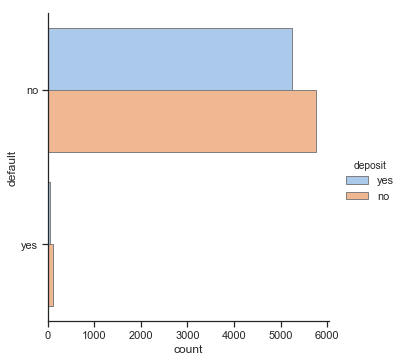

<Figure size 936x936 with 0 Axes>

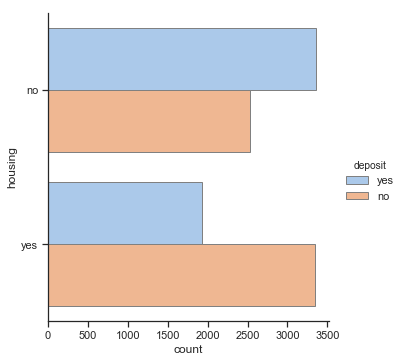

<Figure size 936x936 with 0 Axes>

<Figure size 936x936 with 0 Axes>

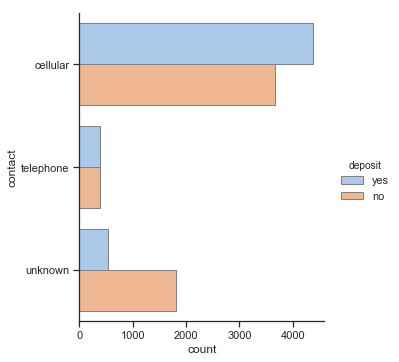

<Figure size 936x936 with 0 Axes>

<Figure size 936x936 with 0 Axes>

In [13]:
data_depo = data[data["deposit"] == "yes"]

categorical_columns = [col for col in data.columns if data[col].dtype == 'object' and
                      col != "deposit"]

for col in categorical_columns:
#     plt.clf()
    df = data.groupby(col)["ID"].nunique()
    df_depot = data_depo.groupby(col)["ID"].nunique()
    result = pd.concat([df_depot, df], axis=1, join='inner')
    result["percentage_deposit"] = result.iloc[:,0]/result.iloc[:,1]
    result = result.iloc[:,2]
    result = result.sort_values(ascending=False)
    print(result)
    plt.figure(figsize = (13,13))
    result = result.reset_index()
    sns.catplot(y=col, hue="deposit", kind="count", order= result[col].tolist(),
            palette="pastel", edgecolor=".5",margin_titles=True,legend=True,
            data=data);
#     plt.savefig(f'/Users/hq2nguye/Desktop/stat441_project/images/catplot_{col}.png')
    print("\n")

## Correlation Plots for Top Feartures in Gradient Boosting

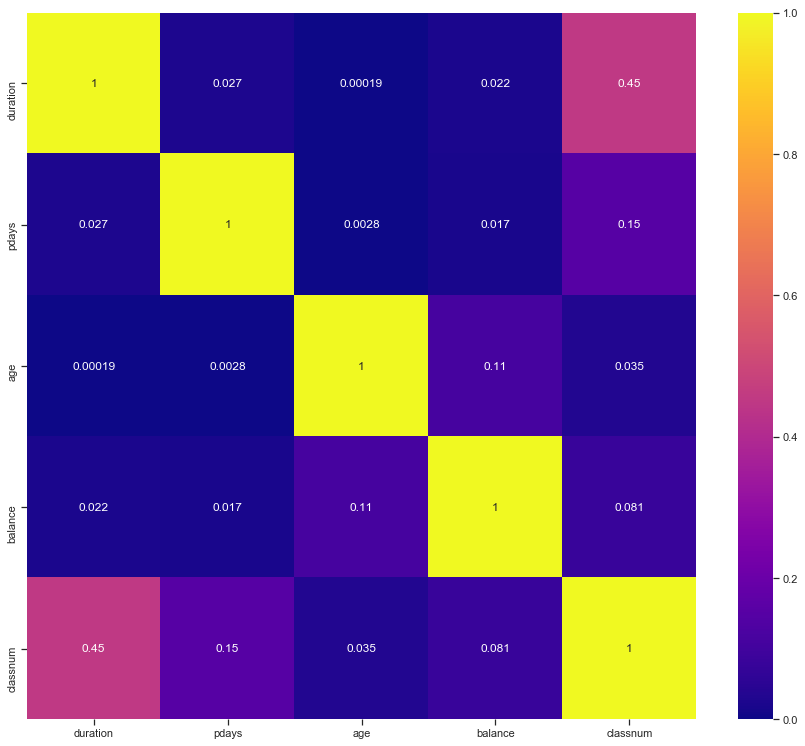

In [14]:
# plt.clf()
# calculate the correlation matrix
data["classnum"] = data["deposit"].apply(lambda x: 1 if x=="yes" else 0)

corr = data.drop(['ID'], axis = 1)[["duration", "pdays", "age", "balance", "classnum"]].corr().abs()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap="plasma", annot=True)
# plt.savefig('/Users/hq2nguye/Desktop/stat441_project/images/corr_heatmap_gbm.png')